# Trying a secondary MCMC fit to account for the exponential portion of the mass function in addition to the original fitting to the bump

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy import cosmology as cosmo
from astropy.cosmology import Planck18
from scipy.integrate import quad
from scipy import integrate
import seaborn as sns
from MCMC_functions import *

sns.set_context('notebook')
sns.set_palette('colorblind')

## Testing the module for sanity:

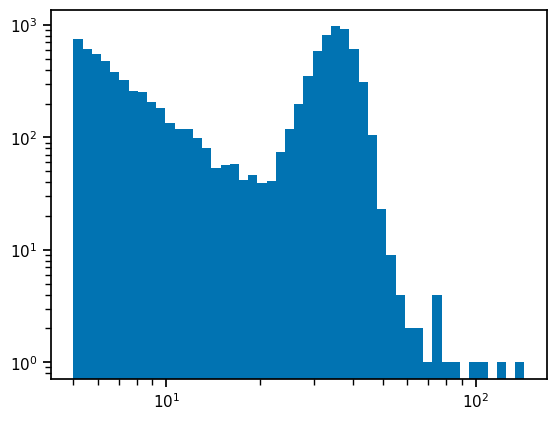

In [8]:
m_source = generate_masses(f=0.5)

plt.hist(m_source, bins=np.logspace(np.log10(min(m_source)), np.log10(max(m_source)), 50))
plt.yscale('log')
plt.xscale('log')

<AxesSubplot:ylabel='Density'>

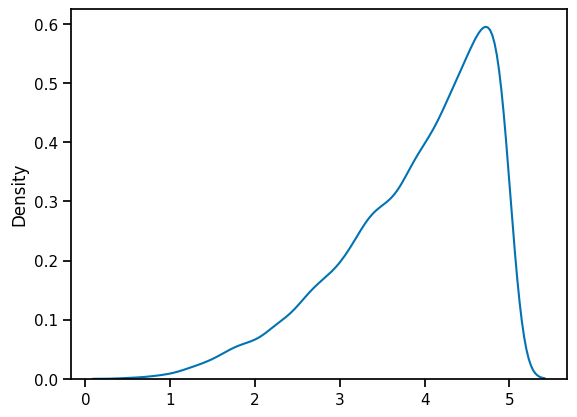

In [9]:
dLs = generate_dLs()
zs = dLs_to_zs(dLs)
m_det = m_source*(1+zs)
sns.kdeplot(zs)

## Ok, now let's try making a double model...
* One distribution keeps the same bump as what's been tried (gaussian~$35M_\odot$)
* Add new distribution trying to account for redshifted BHs in the exponential

Current attempt: model's job is to sort which BHs are on gaussian and isolate them from rest of sample, then perform inference on just those

_only work with detector frame data for now_

In [ ]:
with pm.Model() as sorter_model: